In [15]:
import librosa
import os
import pandas as pd

PATH_TO_DATA = "public_lecture_1/"
MANIFEST = "public_lecture_1.csv"
folders = os.listdir(PATH_TO_DATA)

In [46]:
def get_audio_sample_rate_text(path_to_audio, path_to_text):
    X, sample_rate = librosa.load(path_to_audio,)
    with open(path_to_text, 'r', encoding="utf-8") as reader:
        text = reader.read()
    return X, sample_rate, text

In [29]:
manifest = pd.read_csv(MANIFEST)
manifest.columns = ['path_to_audio', 'path_to_text', 'len']
manifest.head()

,path_to_audio,path_to_text,len
0,public_lecture_1/2/31/6c4f4f0ae5e2.opus,public_lecture_1/2/31/6c4f4f0ae5e2.txt,0.966
1,public_lecture_1/f/eb/0786e48a3f20.opus,public_lecture_1/f/eb/0786e48a3f20.txt,0.969
2,public_lecture_1/e/37/c40e98648b20.opus,public_lecture_1/e/37/c40e98648b20.txt,0.990
3,public_lecture_1/7/c7/bbf58983804d.opus,public_lecture_1/7/c7/bbf58983804d.txt,1.000
4,public_lecture_1/3/97/e44bbab18ded.opus,public_lecture_1/3/97/e44bbab18ded.txt,1.000


In [123]:
dataset = pd.DataFrame()
for index, row in manifest.iterrows():
    try:
        X, sr, text= get_audio_sample_rate_text(row['path_to_audio'], row['path_to_text'])
        df = pd.DataFrame({'X' : [np.array(X)], 'sr' : sr, 'text' : text.split('\n')[0]})
        dataset = dataset.append(df)
    except KeyboardInterrupt:
        dataset = dataset.reset_index()
        break

Датафрейм 'dataset' содержит аудио сжмплы из папки "public_lecture_1/" (STT dataset), загруженные с помощью 'librosa', sample rate и транскрипции к аудио.

In [124]:
dataset.head()

,X,sr,text
0,"[-0.006781096, 0.002923917, 0.019082092, 0.024...",22050,такого не было
0,"[0.0009860961, 0.0016607333, 0.0025275736, 0.0...",22050,ну там телевизор
0,"[0.0038796433, 0.0026135985, -0.001288979, -0....",22050,ещё один случай
0,"[0.019003231, 0.027242612, 0.015416117, -0.005...",22050,и понеслась
0,"[0.0026838735, 0.011850709, 0.015894761, 0.003...",22050,аплодисменты


Далее немного о шумах из книги: Digital Signal Processing in Python (chapter 4.)(  http://greenteapress.com/thinkdsp/thinkdsp.pdf)

**Шум** - сигнал, содержащий компоненты из разных частот (без гармонической структуры)



**1. Uncorrelated uniform (white) noise** - 'uniform' значит, что сигнал содержит случайные числа из равномерного распределения, т.е каждое число равновероятно. 'Uncorrelated' - значит, что числа (из аудио сигнала) независимы, т.е информация об одном значении не дат информации об остальных.

In [171]:
import os
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import UncorrelatedUniformNoise
from thinkdsp import decorate
np.random.seed(17)

#if not os.path.exists('thinkdsp.py'):
#    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

signal = UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

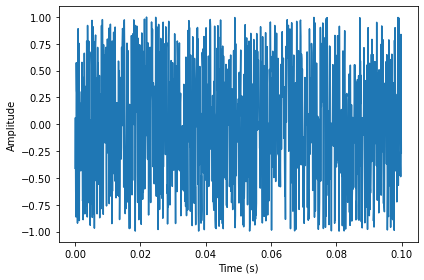

In [172]:
segment = wave.segment(duration=0.1)
segment.plot()
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

График отражает пример спектрограммы UUN (Uncorrelated Uniform Noise), выглядит, достаточно, случайно, НО, нужно кое-что знать об этой рандомности:

- **Распределение:** Распределение рандомного сигнала - это значение и их вероятности. Например, в *равномерном шуме*: числа [-1, +1] и все с одинаковой вероятностью. Как альтернатива **Gaussian noise**, где числа [-inf, + inf] и числа около 0 наиболее вреоятны (с соттветствующей вероятностью).   
- **Корреляция:** В UU шуме значения независимы. Например, в **Brownian noise** каждое значения - сумма предыдущих значений с рандомным "step". Т.е если значение сигнала высокое в определенный момент времени, то мы ожидаем, что оно останется низким.
- **Взаимосвзь:** В UU шуме мощность на всех частотах берётся из одного распределения, т.е одинакова для всех частот. Например, в **Pink noise** мощность обратно пропорциональна частоте, т.е мощность на частоте *f* берется из распределения, среднее которого пропорционально *1/f*

UU-шум в среднем имеет одинаковую мощность на всех частотах, что мы можем подтвердить, посмотрев на нормализованную кумулятивную сумму мощностей, которую называют интегрированным спектром (который является функцией частоты f, который показывает совокупную мощность в спектре вплоть до f.):

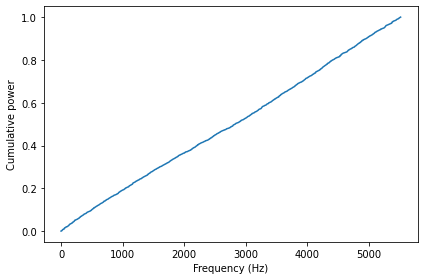

In [173]:
spectrum = wave.make_spectrum()
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Cumulative power')

Прямая линия на этом рисунке показывает, что шум UU в среднем имеет одинаковую мощность на всех частотах. По аналогии со светом шум с этим свойством называется «белым шумом».

Для шума UU мы можем более четко увидеть взаимосвязь между мощностью и частотой, посмотрев на интегрированный спектр, который является функцией частоты f, который показывает совокупную мощность в спектре вплоть до f.

**2. Brownian (red) noise** (по аналогии с броуновским движением): UU шум не коррелированный, т.е каждое значени не зависит от оставльных. Как альтернатива **Brownian noise:** в котором каждое значение - сумма предыдущих с некоторым шагом. 
При одномерном случайном блуждании частица перемещается вверх или вниз на случайную величину на каждом временном шаге. Местоположение частицы в любой момент времени - это сумма всех предыдущих шагов.

In [174]:
signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

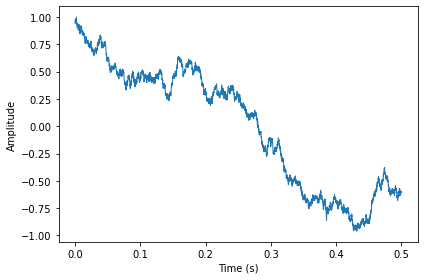

In [175]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

Форма wave колеблется вверх и вниз, но между последовательными значениями существует четкая корреляция. Когда амплитуда высокая, она, как правило, остается высокой, и наоборот.

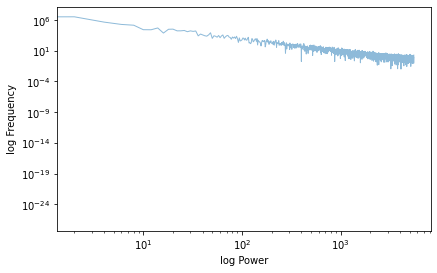

In [186]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=1, alpha=0.5)
decorate(xlabel='log Power',
         ylabel='log Frequency')
plt.xscale('log')
plt.yscale('log')

Чтобы более четко увидеть форму спектра, мы можем построить график мощности и частоты в логарифмическом масштабе. Почти вся мощность приходится на самые низкие частоты; более высокочастотные компоненты не видны. Отношение между мощностью и частотой шумное, но примерно линейное.

Метод 'estimate_slop' использует SciPy для вычисления МНК для мощности спектра.

Он отбрасывает первый компонент спектра, потому что этот компонент соответствует f = 0, а log(0) не определен, 'estimate_slope' возвращает результат из scipy.stats.linregress, который является объектом, который содержит предполагаемый наклон и точку пересечения, коэффициент детерминации (R2), p-value и стандартную ошибку. Для наших целей нам понадобится только наклон.

Для **Brownian noise** наклон силы спектра = -2 (почему - написано в гл.9), можно написать соотношение:
$$log P = k - 2 log f \\ P = K/f^2$$ 
$P$ - power, $f$ - frequency, $k$ - intercept of the line(not important)

Т.е силы сигнала в **Brownian noise** пропорциональна $1/f^2$

**3. Pink noise** - обобщение **Red noise**, описывается как:
$$P = K/f^{\beta}$$

- Если $\beta = 0$, сила - константна для всех частот (**White noise**)
- Если $\beta = 2$, (**Red noise**)
- Если $\beta \in [0, 2]$ -  что-то между Red и White, это и есть **Pink noise**

Самый простой - создать белый шум, а затем применить фильтр нижних частот с желаемой экспонентой. thinkdsp предоставляет класс, представляющий сигнал розового шума:

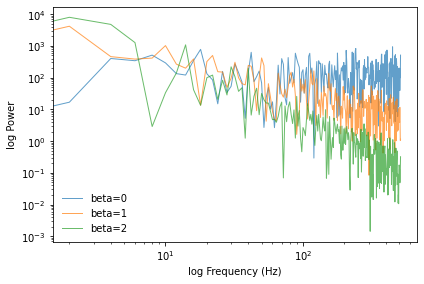

In [191]:
betas = [0, 1, 2]

for beta in betas:
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=0.5, framerate=1024)
    spectrum = wave.make_spectrum()
    spectrum.hs[0] = 0
    label = f'beta={beta}'
    spectrum.plot_power(linewidth=1, alpha=0.7, label=label)
    
decorate(xlabel='log Frequency (Hz)',
         ylabel='log Power')
plt.xscale('log')
plt.yscale('log')

Иллюстрация **White, Red and pink** шумов - зависимость мощности от частоты в log шкале.

**4. Uncorrelated Gaussian (UG) noise** - Спектр в среднем имеет одинаковую мощность на всех частотах, поэтому UG также белый. И у него есть еще одно интересное свойство: спектр шума UG также является шумом UG. Точнее, действительная и мнимая части спектра - это некоррелированные гауссовы значения.

Спектр шума UU - это тоже шум UG, по крайней мере, приблизительно. Фактически, согласно центральной предельной теореме, спектр почти любого некоррелированного шума приблизительно гауссовский, если распределение имеет конечное среднее значение и стандартное отклонение, а количество отсчетов велико.

In [213]:
from thinkdsp import *

def read_opus(filename):
    X, sample_rate = librosa.load(filename)
    wave = Wave(X, framerate=sample_rate)

    return wave

def get_sample_manifest(manifest_, index):
    #index = np.random.randint(0, len(manifest_))
    manifest_row = manifest_.iloc[index]
    wave =  read_opus(manifest_row['path_to_audio'])
    _, _, text = get_audio_sample_rate_text(manifest_row['path_to_audio'], manifest_row['path_to_text'])
    print("text: ", text)
    return wave.make_audio()

In [214]:
get_sample_manifest(manifest, 0)

text:  такого не было



In [215]:
get_sample_manifest(manifest, 10) # correct text: "там я не знаю, если кто-то помнит"

text:  если кто то помнит



In [216]:
get_sample_manifest(manifest, 16)

text:  прости меня



In [217]:
get_sample_manifest(manifest, 20)

text:  ну она дождалась



In [218]:
get_sample_manifest(manifest, 40)

text:  спасибо большое



In [219]:
get_sample_manifest(manifest, 60) # в конце еще сказано слово "мы"

text:  значит слева написано



In [220]:
get_sample_manifest(manifest, 500)

text:  но самое главное



In [221]:
get_sample_manifest(manifest, 1100)

text:  это было благоустройство вот этой аллеи

